# Notebook to manually tune sequnce models and add click 0 data

In [1]:
import numpy as np
import pandas as pd
import s3fs
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Concatenate
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
import pyarrow
import boto3
import pyarrow.parquet as pq
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, average_precision_score, 
                             precision_recall_curve, auc, roc_auc_score, plot_precision_recall_curve, plot_roc_curve)
from matplotlib import pyplot as plt
import pickle

In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 0)
s3 = s3fs.S3FileSystem()

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display

### Now we use all the data

In [4]:
feature_path = 's3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/may_2021_page_action_no_checkout_leakage.parquet'

In [5]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

### Now we evaluate the class balance

In [42]:
summary = feature_table.groupby('LABEL')['udo_tealium_session_id'].count().reset_index()

In [43]:
summary['FRACTION'] = summary['udo_tealium_session_id']/summary['udo_tealium_session_id'].sum()

In [44]:
summary

LABEL  udo_tealium_session_id             FRACTION
0  0      5542030                               0.944
1  1      327997                                0.056

In [49]:
class_weight_postive = summary[summary.LABEL==0]['FRACTION'].values [0]

In [51]:
class_weight_negative = summary[summary.LABEL==1]['FRACTION'].values [0]

In [50]:
class_weight_postive

0.9441234256673777

In [53]:
class_weight_negative

0.05587657433262232

In [55]:
class_weight_dict = {0: class_weight_negative, 
                     1: class_weight_postive}

In [680]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=1.0, random_state=3)

### Now split the data into train and test

In [681]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [682]:
len(X_train)

5283024

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [683]:
data_dict = {}

In [684]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [685]:
def process_sentences(sentence_series: pd.Series,
                      maxlen: int, 
                      padding: str = 'pre', 
                      truncating: str ='post',
                      tokenizer: Tokenizer = None,
                      num_words: int = None,) -> np.array:
    """Function to use a fit tokenizer to convert a pandas series of sentences into a numpy array
    of integers.  This numpy array will have the same number of rows as elements of the sentence
    series and maxlen number of columns. This matrix will represent each word in the sequence by an 
    integer, with 1 standing for the UNKNOWN token, 0 for padding, and numbers representing the 
    vocabulary size defined by fit_tokenizer.
    
    Parameters
    ----------
     sentence_series: pd.Series
        A series of text elements, each containing a sentence of words separated by spaces
         
     maxlen: int
         The maximum number of words in a sentence to be kept
         
     padding: str
         If 'pre', the sentences are left padded with 0 values if less than maxlen
         if 'post' the sentences are right padded with 0 values if less than maxlen
         
     truncating: str
         If 'pre', the sentences are truncated from the left if greater than maxlen.
         This keeps the earliest sequence values
         if 'post' the sentences are truncated from the right if greater than maxlen.
         This keeps the latest sequence values
         
     tokenizer: Tokenizer
         A fit Tokenizer object. If none, a new tokenizer will be fit on the data
         
     num_words: int
         The number of words to be in the vocabulary for this sequence.  This must
         be specified if fit_tokenizer is None.
    
    Returns
    -------
    A numpy array of containing a row for each sequence and a column for each token. The
    second dimension is always maxlen.
    """
    # Convert the series of sentences to a list
    sentence_list = sentence_series.tolist()
    
    # Fit the fit tokenizer if necessary
    if tokenizer is None:
        tokenizer = Tokenizer(
            num_words=num_words,
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True, 
            split=', ', 
            char_level=False, 
            oov_token="UNKNOWN")
        tokenizer.fit_on_texts(sentence_list)
    
    # Create the sequences of indicies
    sequences = tokenizer.texts_to_sequences(sentence_list)
    
    # Truncate and pad the sequences
    output = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    return output, tokenizer   

In [686]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

In [687]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [688]:
len(data_dict['TYPE_SENTENCE']['train'])

5283024

In [689]:
write_pickle_to_s3(bucket='aap-aiexpzone-pii-mktg-datascientist-results-prod', key='ScottSmith/may_2021_sequence_dict.pkl', data=data_dict)

In [690]:
data_dict = read_pickle_from_s3(bucket='aap-aiexpzone-pii-mktg-datascientist-results-prod', key='ScottSmith/may_2021_sequence_dict.pkl')

### Now we try four GPUs 

In [712]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    type_sentence_indicies = Input(shape=input_shape, dtype='int32')
    category_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=15, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=12, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=15, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=1, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    type_emb = Embedding(input_dim=51, output_dim=3, trainable=True, mask_zero=True)(type_sentence_indicies)
    category_emb = Embedding(input_dim=1901, output_dim=7, trainable=True, mask_zero=True)(category_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb, type_emb, category_emb])
    
    # Propagate the embeddings through an LSTM layer with 256-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=256, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate the embeddings through another LSTM layer with 256-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=256, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 256-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=256, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies, type_sentence_indicies, category_sentence_indicies], outputs=X)
    
    return model

In [819]:
strategy = tensorflow.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [848]:
with strategy.scope():
    model = ClickStreamPageModel(7)

In [849]:
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_223 (InputLayer)         [(None, 7)]          0           []                               
                                                                                                  
 input_224 (InputLayer)         [(None, 7)]          0           []                               
                                                                                                  
 input_225 (InputLayer)         [(None, 7)]          0           []                               
                                                                                                  
 input_226 (InputLayer)         [(None, 7)]          0           []                               
                                                                                           

In [850]:
with strategy.scope():
    aupr = tensorflow.keras.metrics.AUC(
        num_thresholds=20,
        curve="PR",
        summation_method="interpolation",
        name='aupr',
        dtype=None,
        thresholds=None,
        multi_label=False,
        num_labels=None,
        label_weights=None,
        from_logits=False,
    )

In [851]:
with strategy.scope():
    lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1161,
    decay_rate=0.9,
    staircase=True)

### We define callbacks for early stopping and saving the best model

In [875]:
with strategy.scope():
    early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor="val_aupr",
        min_delta=0,
        patience=3,
        verbose=0,
        mode="max",
        baseline=None,
        restore_best_weights=True,
    )

### batch size 4096

In [853]:
with strategy.scope():
    model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy', aupr])

In [854]:
#with strategy.scope():
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train'],
           data_dict['TYPE_SENTENCE']['train'],
           data_dict['CATEGORY_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 4096, 
           shuffle=True,
           class_weight=None,
           validation_split=0.10)

Epoch 1/100
1161/1161 [==============================] - 129s 78ms/step - loss: 0.2076 - accuracy: 0.9431 - aupr: 0.1534 - val_loss: 0.1410 - val_accuracy: 0.9435 - val_aupr: 0.3525
Epoch 2/100
1161/1161 [==============================] - 80s 69ms/step - loss: 0.1385 - accuracy: 0.9444 - aupr: 0.3657 - val_loss: 0.1394 - val_accuracy: 0.9441 - val_aupr: 0.3645
Epoch 3/100
1161/1161 [==============================] - 80s 69ms/step - loss: 0.1356 - accuracy: 0.9448 - aupr: 0.3803 - val_loss: 0.1395 - val_accuracy: 0.9444 - val_aupr: 0.3689
Epoch 4/100
1161/1161 [==============================] - 80s 69ms/step - loss: 0.1335 - accuracy: 0.9451 - aupr: 0.3914 - val_loss: 0.1403 - val_accuracy: 0.9443 - val_aupr: 0.3725
Epoch 5/100
1161/1161 [==============================] - 80s 69ms/step - loss: 0.1318 - accuracy: 0.9454 - aupr: 0.4009 - val_loss: 0.1420 - val_accuracy: 0.9445 - val_aupr: 0.3690


In [855]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [856]:
validation_loss = validation_loss[:-1]

In [857]:
training_loss = training_loss[1:]

In [858]:
validation_aupr = validation_aupr[:-1]

In [859]:
training_aupr = training_aupr[1:]

In [860]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

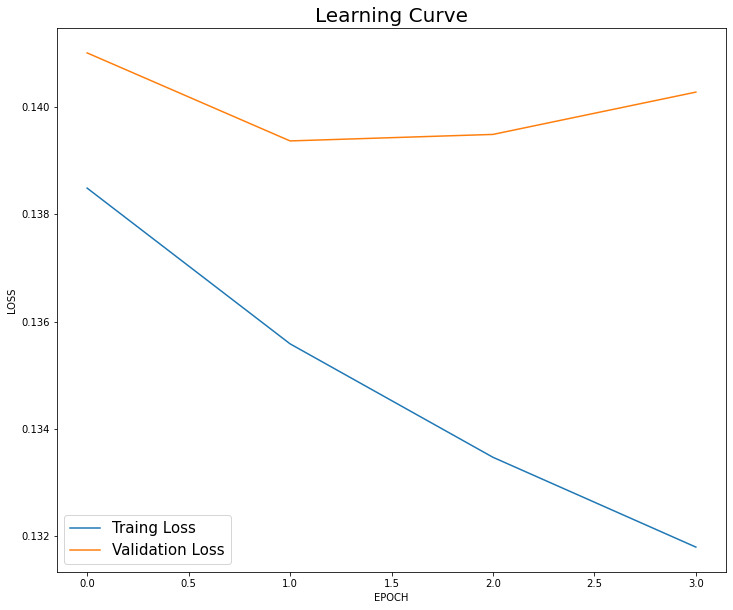

In [861]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

In [862]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.056, 0.0, 5.0, colors='red', label="Null Classifier (AUPR = 0.056)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [863]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [864]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test'], 
           data_dict['TYPE_SENTENCE']['test'],
           data_dict['CATEGORY_SENTENCE']['test']])


In [873]:
predicted_classes_test = np.where(predictions_test > 0.33, 1, 0)

In [874]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  535034               19169          
true: converted      19391                13409          


              precision    recall  f1-score   support

           0       0.97      0.97      0.97    554203
           1       0.41      0.41      0.41     32800

    accuracy                           0.93    587003
   macro avg       0.69      0.69      0.69    587003
weighted avg       0.93      0.93      0.93    587003

The area under the PR curve is approximately 0.37


In [876]:
test = pd.read_csv('s3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/prod/email_score.csv', header=0)

In [877]:
test.dtypes

INDV_ID                  int64  
SCORE                    float64
ECOMM_ENGAGED            int64  
SCORE_DATE               object 
LOAD_TS                  int64  
MARGIN_GRADE             object 
DIY_SKILLSET             object 
FREQUENCY_STATUS         object 
CUSTOMER_LIFETIME        object 
PREFERRED_FULFILLMENT    object 
PREFERRED_CHANNEL        object 
SEGMENT_GROUP            object 
RECENCY_STATUS           object 
PROMOTION_LOCATION       object 
PROMOTION_TEXT           object 
EMAIL                    object 
dtype: object

In [878]:
len(test)

13434925

In [879]:
test = test[['EMAIL', 'SCORE']]

In [883]:
test.isnull().count()

EMAIL    13434925
SCORE    13434925
dtype: int64

In [885]:
test.to_csv('email_sensitivity_scores_01052022.csv', header=True)

### batch size 32

In [82]:
#with strategy.scope():
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train'],
           data_dict['TYPE_SENTENCE']['train'],
           data_dict['CATEGORY_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.50)

Epoch 1/100
8255/8255 [==============================] - 321s 38ms/step - loss: 0.1713 - accuracy: 0.9426 - aupr: 0.2928 - val_loss: 0.1590 - val_accuracy: 0.9415 - val_aupr: 0.2865
Epoch 2/100
8255/8255 [==============================] - 308s 37ms/step - loss: 0.1533 - accuracy: 0.9418 - aupr: 0.3087 - val_loss: 0.1511 - val_accuracy: 0.9419 - val_aupr: 0.3113
Epoch 3/100
8255/8255 [==============================] - 308s 37ms/step - loss: 0.1470 - accuracy: 0.9422 - aupr: 0.3283 - val_loss: 0.1473 - val_accuracy: 0.9423 - val_aupr: 0.3234
Epoch 4/100
8255/8255 [==============================] - 308s 37ms/step - loss: 0.1434 - accuracy: 0.9426 - aupr: 0.3401 - val_loss: 0.1454 - val_accuracy: 0.9425 - val_aupr: 0.3304
Epoch 5/100
8255/8255 [==============================] - 308s 37ms/step - loss: 0.1406 - accuracy: 0.9431 - aupr: 0.3512 - val_loss: 0.1444 - val_accuracy: 0.9427 - val_aupr: 0.3353
Epoch 6/100
8255/8255 [==============================] - 308s 37ms/step - loss: 0.1386 - a

In [83]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [84]:
validation_loss = validation_loss[:-1]

In [85]:
training_loss = training_loss[1:]

In [86]:
validation_aupr = validation_aupr[:-1]

In [87]:
training_aupr = training_aupr[1:]

In [88]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(11, 11, 11, 11)

In [89]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

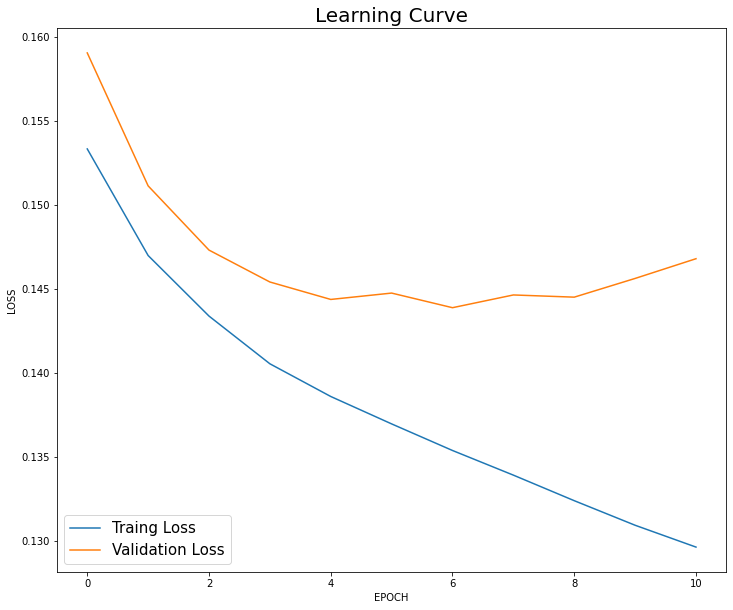

In [90]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

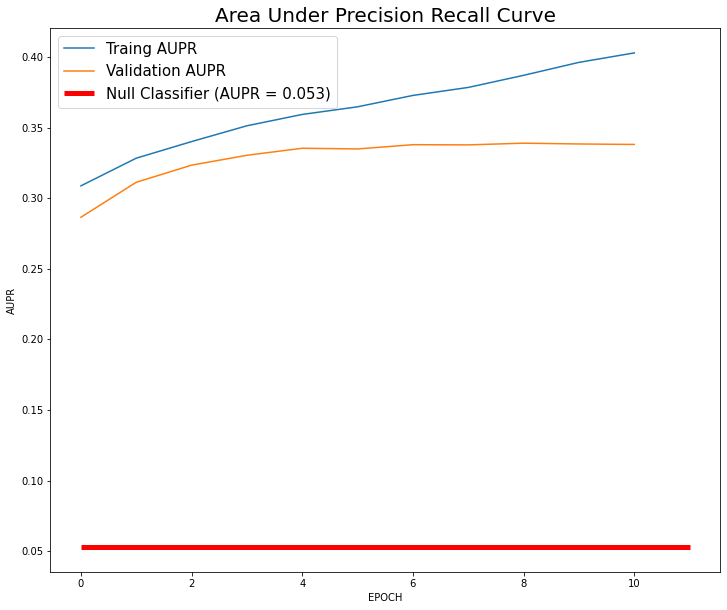

In [91]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [92]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [94]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train'], 
           data_dict['TYPE_SENTENCE']['train'],
           data_dict['CATEGORY_SENTENCE']['train']
                                  ])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [95]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  495276               3506           
true: converted      26238                3282           


              precision    recall  f1-score   support

           0       0.95      0.99      0.97    498782
           1       0.48      0.11      0.18     29520

    accuracy                           0.94    528302
   macro avg       0.72      0.55      0.58    528302
weighted avg       0.92      0.94      0.93    528302

The area under the PR curve is approximately 0.37


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [96]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test'], 
           data_dict['TYPE_SENTENCE']['test'],
           data_dict['CATEGORY_SENTENCE']['test']])


In [107]:
predicted_classes_test = np.where(predictions_test > 0.325, 1, 0)

In [108]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  53387                2034           
true: converted      1953                 1327           


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     55421
           1       0.39      0.40      0.40      3280

    accuracy                           0.93     58701
   macro avg       0.68      0.68      0.68     58701
weighted avg       0.93      0.93      0.93     58701

The area under the PR curve is approximately 0.35
